In [1]:
#!pip install ISLP

# Zadanie 7

In this problem, you will use support vector approaches in order to
predict whether a given car gets high or low gas mileage based on the
Auto data set.

## 0) Wczytanie danych, przegląd, preparacja

### Import potrzebnych bibliotek

In [2]:
import numpy as np
import pandas as pd

In [3]:
import sklearn.model_selection as skm
from ISLP import load_data
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score

from matplotlib.pyplot import subplots

### Mamy pobrany zestaw danych Auto.csv z oficjalnego githuba ISLP, wczytajmy go i przyjrzyjmy się co zawiera

In [4]:
df = load_data('Auto')

In [5]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, chevrolet chevelle malibu to chevy s-10
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 27.6+ KB


### Jak widzimy, nie mamy wartości NULL oraz dane mają właściwe typy

### Będziemy chcieli użyć metod wektorów wspierających do predykcji czy dany samochód ma wysokie czy też niskie spalanie.

## a) Utworzenie binarnej kolumny oraz przygotowanie danych pod SVC

Create a binary variable that takes on a 1 for cars with gas
mileage above the median, and a 0 for cars with gas mileage
below the median.

### Chcemy stworzyć kolumnę w naszym dataframe z wartościami 0 - niskie spalanie, 1 - wysokie spalanie.

### Zrobimy to przy użyciu mediany, dzięki której podzielimy nasz zbiór na pół.

In [7]:
mpg_median = df['mpg'].median()
print(mpg_median)

22.75


In [8]:
df['mpg01'] = np.where(df['mpg']>=mpg_median, 1, 0)

In [9]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01
name,,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1,0
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1,0
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1,0
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1,0
ford torino,17.0,8,302.0,140,3449,10.5,70,1,0


### Przygotujmy teraz nasz zbiór cech X na podstawie którego będziemy predyktować target y, czyli czy samochód ma duże czy też małe spalanie.

### Opuszczamy mpg które nic nie wniesie w nasz model predykcyjny i mpg01, które będzie naszym targetem

In [10]:
X = df.drop(columns=["mpg", "mpg01"], axis=1) # features
y = df["mpg01"] #target

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, chevrolet chevelle malibu to chevy s-10
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cylinders     392 non-null    int64  
 1   displacement  392 non-null    float64
 2   horsepower    392 non-null    int64  
 3   weight        392 non-null    int64  
 4   acceleration  392 non-null    float64
 5   year          392 non-null    int64  
 6   origin        392 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 32.6+ KB


### Podzielmy nasze dane na zbiór treningowy i testowy w stosunku 8:2 (train:test) w celu rzetelnego sprawdzenia skuteczności naszego modelu

In [12]:
(X_train, 
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                y,
                                test_size=0.2,
                                random_state=0)

In [13]:
print(f"Wielkość zbioru treningowego (predictors): {len(X_train)}")
print(f"Wielkość zbioru treningowego (target): {len(y_train)}")
print(f"Wielkość zbioru testowego (predictors): {len(X_test)}")
print(f"Wielkość zbioru testowego (target): {len(y_test)}")

Wielkość zbioru treningowego (predictors): 313
Wielkość zbioru treningowego (target): 313
Wielkość zbioru testowego (predictors): 79
Wielkość zbioru testowego (target): 79


### Konwersja na tablice NumPy, które są bardziej przyjaźniejsze dla komputera 

In [14]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.ravel(np.array(y_train))
y_test = np.ravel(np.array(y_test))

### Dokonajmy standaryzacji cech zbioru treningowego, która pozytywnie wpływa na efekty klasyfikatora

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## b) Dopasujemy klasyfikator z jądrem liniowym pod nasze dane

Fit a support vector classifier to the data with various values of
C, in order to predict whether a car gets high or low gas mileage.
Report the cross-validation errors associated with different val-
ues of this parameter. Comment on your results. Note you will
need to fit the classifier without the gas mileage variable to pro-
duce sensible results.

### Znajdźmy najbardziej optymalny parametr z ustalonego zbioru C dla jądra liniowego

In [16]:
svm_linear = SVC(kernel='linear')

In [17]:
# 5-krotna walidacja krzyżowa
kfold_linear = skm.KFold(5, 
                  random_state=7,
                  shuffle=True)
# automatyczne przeszukiwanie siatki parametrów
grid_linear = skm.GridSearchCV(svm_linear,
                        {'C':[0.001, 0.01, 0.1, 1, 5, 10, 100]},
                        refit=True,
                        cv=kfold_linear,
                        scoring='accuracy')
grid_linear.fit(X_train, y_train)
print("Najlepsze parametry dla liniowego")
grid_linear.best_params_

Najlepsze parametry dla liniowego


{'C': 10}

In [18]:
print("Kolejne błędy kros-walidacji: \n", 1-grid_linear.cv_results_[('mean_test_score')])

Kolejne błędy kros-walidacji: 
 [0.16287762 0.08008193 0.09595494 0.07987711 0.07352791 0.0703533
 0.07352791]


In [19]:
new_grid = np.linspace(5, 10, 100)
grid_linear = skm.GridSearchCV(svm_linear,
                        {'C':new_grid},
                        refit=True,
                        cv=kfold_linear,
                        scoring='accuracy')
grid_linear.fit(X_train, y_train)
print("Najlepsze parametry dla liniowego")
grid_linear.best_params_

Najlepsze parametry dla liniowego


{'C': 9.393939393939394}

In [20]:
print("Kolejne błędy kros-walidacji: \n", 1-grid_linear.cv_results_[('mean_test_score')])

Kolejne błędy kros-walidacji: 
 [0.07352791 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791
 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791
 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791
 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791
 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791
 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791
 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791
 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791
 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791
 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791
 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791
 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791
 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791
 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791 0.07352791
 0.07352791 0.07352791 0.07352

Nie ma różnicy między błędem kroswalidacji przy nowym C i przy C=10, ale warto było to zrobić, w przypadku gdy optymalne C byłoby np. równe 7, pierwsze podejście by go nie wychwyciło.

In [21]:
print("Dokładność na zbiorze treningowym:", grid_linear.best_score_)

Dokładność na zbiorze treningowym: 0.9296466973886328


In [22]:
y_pred_linear = grid_linear.predict(X_test)

In [23]:
test_accuracy_linear = accuracy_score(y_test, y_pred_linear)
print("Dokładność na zbiorze testowym:", test_accuracy_linear)

Dokładność na zbiorze testowym: 0.8734177215189873


## c) Powtórzmy powyższe kroki, tym razem dla SVC z jądrem radialnym oraz poly

Now repeat (b), this time using SVMs with radial and polyno-
mial basis kernels, with different values of gamma and degree and
C. Comment on your results.

### Chcemy powtórzyć poszukiwania najlepszych parametrów, tym razem używając SVC z innymi jądrami

### Zacznijmy od jądra radialnego (RBF)

In [24]:
svm_rbf = SVC(kernel="rbf")

In [25]:
kfold_rbf = skm.KFold(5, 
                  random_state=7,
                  shuffle=True)
grid_rbf = skm.GridSearchCV(svm_rbf,
                        {'C':[0.001, 0.01, 0.1, 1, 5, 10, 100],
                         'gamma':[0.5, 1, 2, 3, 4]},
                        refit=True,
                        cv=kfold_rbf,
                        scoring='accuracy');
grid_rbf.fit(X_train, y_train)
print("Najlepsze parametry dla rbf")
grid_rbf.best_params_

Najlepsze parametry dla rbf


{'C': 5, 'gamma': 1}

In [26]:
print("Kolejne błędy kros-walidacji: \n", 1-grid_rbf.cv_results_[('mean_test_score')])

Kolejne błędy kros-walidacji: 
 [0.54618536 0.54618536 0.54618536 0.54618536 0.54618536 0.54618536
 0.54618536 0.54618536 0.54618536 0.54618536 0.08003072 0.08330773
 0.29677419 0.53328213 0.54618536 0.06733231 0.0608807  0.06728111
 0.07368152 0.08653354 0.0640553  0.05765489 0.07368152 0.07695853
 0.08330773 0.0640041  0.0640041  0.07368152 0.07695853 0.08648233
 0.08320533 0.08330773 0.07368152 0.08013313 0.08648233]


Powtarzając szukanie dla C:

In [27]:
new_grid = np.linspace(3, 7, 100)
grid_rbf = skm.GridSearchCV(svm_rbf,
                        {'C':new_grid,
                         'gamma':[0.5, 1, 2, 3, 4]},
                        refit=True,
                        cv=kfold_rbf,
                        scoring='accuracy')
grid_rbf.fit(X_train, y_train)
print("Najlepsze parametry dla rbf")
grid_rbf.best_params_

Najlepsze parametry dla rbf


{'C': 4.212121212121212, 'gamma': 1}

In [28]:
print("Dokładność na zbiorze treningowym:", grid_rbf.best_score_)

Dokładność na zbiorze treningowym: 0.9423451100870455


In [29]:
y_pred_rbf = grid_rbf.predict(X_test)

In [30]:
test_accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
print("Dokładność na zbiorze testowym:", test_accuracy_rbf)

Dokładność na zbiorze testowym: 0.8987341772151899


### Teraz sprawdźmy dla jądra wielomianowego (poly)

In [31]:
svm_poly = SVC(kernel="poly")

In [32]:
kfold_poly = skm.KFold(5, 
                  random_state=7,
                  shuffle=True)

grid_poly = skm.GridSearchCV(svm_poly,
                        {'C':[0.001, 0.01, 0.1, 1, 5, 10, 100],
                         'degree':[2,3,4,5]},
                        refit=True,
                        cv=kfold_poly,
                        scoring='accuracy');

grid_poly.fit(X_train, y_train)
print("Najlepsze parametry dla poly")
grid_poly.best_params_

Najlepsze parametry dla poly


{'C': 5, 'degree': 3}

In [33]:
print("Kolejne błędy kros-walidacji: \n", 1-grid_poly.cv_results_[('mean_test_score')])

Kolejne błędy kros-walidacji: 
 [0.54618536 0.47598566 0.4952893  0.42140297 0.53993856 0.2843318
 0.40235535 0.31935484 0.31623144 0.24935996 0.27798259 0.27480799
 0.278085   0.09912954 0.21428571 0.10870456 0.16917563 0.07357911
 0.18530466 0.12155658 0.16282642 0.08003072 0.16282642 0.12150538
 0.1499744  0.07690732 0.13097798 0.09923195]


In [34]:
print("Dokładność na zbiorze treningowym:", grid_poly.best_score_)

Dokładność na zbiorze treningowym: 0.9264208909370198


In [35]:
y_pred_poly = grid_poly.predict(X_test)

In [36]:
test_accuracy_poly = accuracy_score(y_test, y_pred_poly)
print("Dokładność na zbiorze testowym:", test_accuracy_poly)

Dokładność na zbiorze testowym: 0.8987341772151899


### Jak widać jądro rbf daje najlepsze rezultaty, o dokładności ~0.9 na zbiorze testowym. Nie jest to perfekcyjny wynik jednak mamy dość jasną zależność cech do targetu.

## d) Spróbujmy zwizulizować granice decyzyjne dla wybranej pary cech (dla trzech różnych jąder)

Make some plots to back up your assertions in (b) and (c).
Hint: In the lab, we used the plot_svm() function for fitted SVMs.
When p > 2, you can use the keyword argument features to
create plots displaying pairs of variables at a time.

In [409]:
X_train.shape

(313, 7)

- 0   cylinders     392 non-null    int64  
- 1   displacement  392 non-null    float64
- 2   horsepower    392 non-null    int64  
- 3   weight        392 non-null    int64  
- 4   acceleration  392 non-null    float64
- 5   year          392 non-null    int64  
- 6   origin        392 non-null    int64  

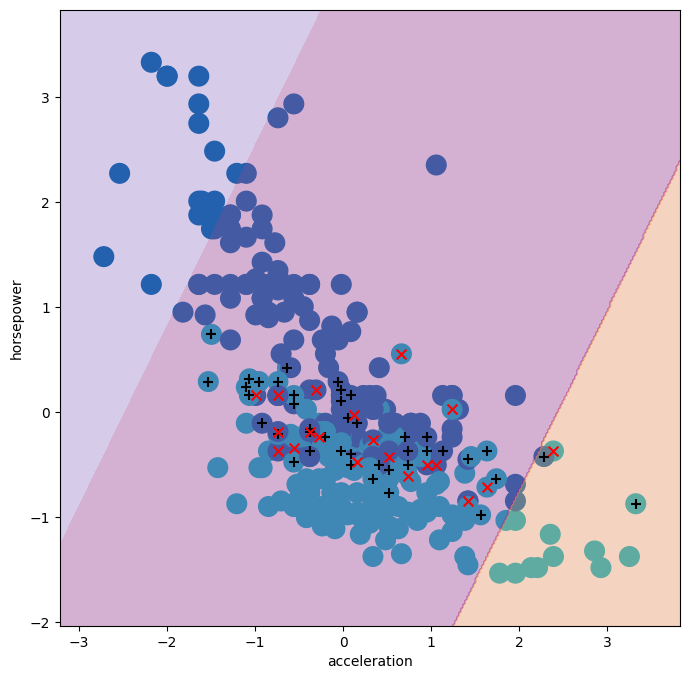

In [410]:
fig, ax = subplots(figsize=(8,8))
plot_svm(X_train,
         y_train,
         grid.best_estimator_,
         (4,2),
         ax=ax)
ax.set_xlabel(X.columns[4])
ax.set_ylabel(X.columns[2]);


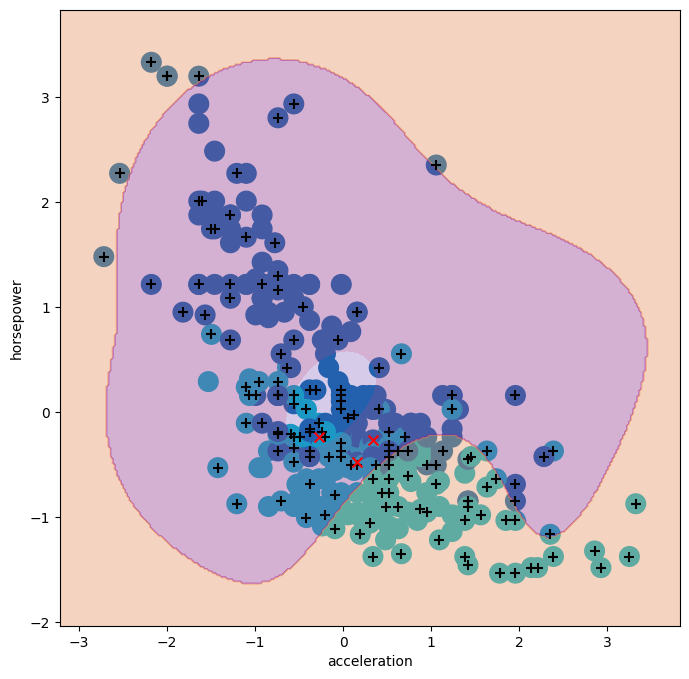

In [411]:
fig, ax = subplots(figsize=(8,8))
plot_svm(X_train,
         y_train,
         grid_rbf.best_estimator_,
         (4,2),
         ax=ax)
ax.set_xlabel(X.columns[4])
ax.set_ylabel(X.columns[2]);


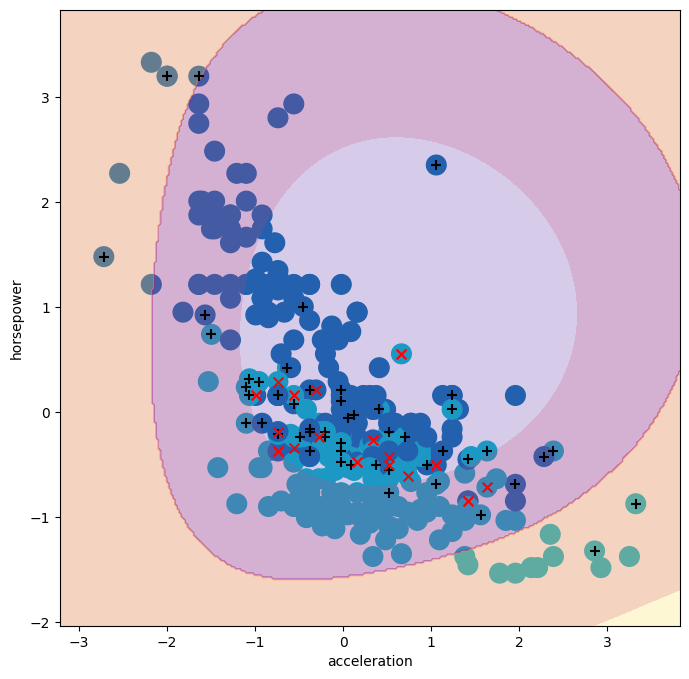

In [412]:
fig, ax = subplots(figsize=(8,8))
plot_svm(X_train,
         y_train,
         grid_poly.best_estimator_,
         (4,2),
         ax=ax)
ax.set_xlabel(X.columns[4])
ax.set_ylabel(X.columns[2]);


### Mamy aż 6 cech, wykresy granic decyzyjnych SVC dla par cech nie mówią nam zbyt wiele